### <center> **Part #1 - MAB** </center>

#### <center> **Adaptive Treatment Selection with Multi-Armed Bandits** </center>


In [243]:
from __future__ import annotations

import logging
import random
import sys
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [244]:
logger = logging.getLogger("DRL")
logger.propagate = False

for handler in logger.handlers:
    logger.removeHandler(handler)

logger.setLevel(logging.INFO)
stream_handler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter("%(levelname)s | %(message)s")
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)


In [245]:
# Load dataset
clinical_trials = pd.read_csv("./data/clinical_trial.csv")

In [246]:
# Define the environment
class Clinic:
    """Clinic environment for simulating patient treatments and outcomes."""

    def __init__(self, patient_records: pd.DataFrame) -> None:
        """Initialize the Clinic environment.

        Parameters
        ----------
        patient_records : pd.DataFrame
            DataFrame containing patient records.

        """
        self._patient_records = patient_records

    def treatment_effect(self, patient_record: pd.Series) -> int:
        """Treatment Effect.

        Reward based on the treatment
        If the patient status is censoring (label == 0) and the CD4 count improves (cd420 > cd40),
        the treatment was successful and the reward should be 1 else 0.

        Parameters
        ----------
        patient_record : pd.Series
            Patient details.

        Returns
        -------
        int
            Whether treatment was successful or not.

        """
        if (
            # Patient is censoring
            patient_record["label"] == 0
        ) and (
            # CD4 count is improving
            patient_record["cd420"] > patient_record["cd40"]
        ):
            return 1
        return 0

    def get_patient_record(self, patient_id: int) -> pd.Series:
        """Retrieve a patient record by patient ID.

        Parameters
        ----------
        patient_id : int
            ID of the patient. This is the index of the patient record in DataFrame.

        Returns
        -------
        pd.Series
            The patient record as a pandas Series.

        """
        return self._patient_records[patient_id]

    # Defining treatments as a property to avoid manual override
    @property
    def treatments(self) -> dict[int, str]:
        """Dictionary of available treatments.

        Returns
        -------
        dict[int, str]
            Mapping of treatment codes to treatment names.

        """
        return {0: "ZDV only", 1: "ZDV + ddI", 2: "ZDV + Zal", 3: "ddI only"}

    def treatment(self) -> int:
        """Randomly select a treatment.

        Returns
        -------
        str
            The id of the randomly selected treatment.

        """
        return random.choice([0, 1, 2, 3])  # noqa: S311

    def treatment_name(self, treatment_id: int) -> str:
        """Randomly select a treatment.

        Parameters
        ----------
        treatment_id : int
            The treatment id to filter patient records.

        Returns
        -------
        str
            The id of the randomly selected treatment.

        """
        return self.treatments[treatment_id]

    def sample_patient_with_treatment(self, treatment_id: int) -> pd.Series:
        """Sample a patient record with the specified treatment.

        Parameters
        ----------
        treatment_id : int
            The treatment id to filter patient records.

        Returns
        -------
        pd.Series
            A randomly sampled patient record with the specified treatment.

        """
        return self._patient_records.loc[self._patient_records["trt"] == treatment_id].sample(1).iloc[0]


In [247]:
class Policy(ABC):
    """Abstract base class for bandit policies."""

    def __init__(self, number_of_arms: int, **kwargs: dict) -> None:  # noqa: D107
        self._number_of_arms = number_of_arms
        self._arm_calls = np.zeros(number_of_arms)
        self._arm_rewards = np.zeros(number_of_arms)
        self._total_calls = 0
        self._kwargs = kwargs

    @abstractmethod
    def select_arm(self) -> int:
        """Select an arm to pull.

        Returns
        -------
        int
            The index of the selected arm.

        """
        ...

    def update_arm_call(self, arm: int, reward: int) -> None:
        """Update the call and reward counts for a given arm.

        Parameters
        ----------
        arm : int
            The index of the arm to update.
        reward : int
            The reward received from pulling the arm.

        """
        self._arm_calls[arm] += 1
        self._arm_rewards[arm] += reward

        self._total_calls += 1


class RandomPolicy(Policy):
    """Policy that selects an arm at random."""

    def select_arm(self) -> int:
        """Select an arm to pull at random.

        Returns
        -------
        int
            The index of the randomly selected arm.

        """
        return np.random.default_rng().integers(0, self._number_of_arms)


class GreedyPolicy(Policy):
    """Policy that selects an arm using the greedy strategy."""

    def select_arm(self) -> int:
        """Select an arm to pull using the greedy strategy.

        Returns
        -------
        int
            The index of the selected arm.

        """
        # If this is the first call select an arm at random
        if self._total_calls == 0:
            return np.random.default_rng().integers(0, self._number_of_arms)

        # Calculate mean reward per arm
        mean_rewards = np.divide(self._arm_rewards, self._arm_calls, where=self._arm_calls != 0)

        # Return the index with maximum reward
        return np.argmax(mean_rewards)


class EpsilonGreedyPolicy(Policy):
    """Policy that selects an arm using the epsilon-greedy strategy."""

    def __init__(self, number_of_arms: int, **kwargs: dict) -> None:  # noqa: D107
        super().__init__(number_of_arms, **kwargs)
        if "epsilon" not in kwargs:
            message = "Missing required input parameter `epsilon`"
            raise TypeError(message)
        self._epsilon = kwargs["epsilon"]

    def select_arm(self) -> int:
        """Select an arm to pull using the epsilon strategy.

        Returns
        -------
        int
            The index of the selected arm.

        """
        if (
            # If this is the first call select an arm at random
            self._total_calls == 0
            or
            # Allow random selection occasionally when the random value is less than epsilon
            np.random.default_rng().random() < self._epsilon
        ):
            return np.random.default_rng().integers(0, self._number_of_arms)

        # Calculate mean reward per arm
        mean_rewards = np.divide(self._arm_rewards, self._arm_calls, where=self._arm_calls != 0)

        # Return the index with maximum reward
        return np.argmax(mean_rewards)


class UCBPolicy(Policy):
    """Policy that selects an arm using the UCB strategy."""

    def select_arm(self) -> int:
        """Select an arm to pull using the Upper Confidence Bound (UCB) strategy.

        Returns
        -------
        int
            The index of the selected arm.

        """
        # Call all arms once before calling the same arm again
        if self._total_calls < self._number_of_arms:
            return self._total_calls

        # Calculate mean reward per arm
        mean_rewards = np.divide(self._arm_rewards, self._arm_calls, where=self._arm_calls != 0)

        # Calculate confidence bounds
        confidence_bounds = np.sqrt(
            2
            * np.log(
                # Total calls + 1 is the current iteration value
                # Total calls is updated after calling the `select_arm` function
                self._total_calls + 1
            )
            / self._arm_calls,
        )

        # Calculate UCB values
        ucb_values = mean_rewards + confidence_bounds
        return np.argmax(ucb_values)

In [248]:
# Function for simulating a policy


def simulate_policy(
    policy: Policy,
    environment: Clinic,
    iterations: int,
    *,
    verbose: bool = False,
) -> tuple[list[str], list[int]]:
    """Simulate a policy interacting with the clinic environment.

    Parameters
    ----------
    policy : Policy
        The bandit policy to use for selecting treatments.
    environment : Clinic
        The clinic environment containing patient records and treatments.
    iterations : int
        Number of iterations to simulate.
    verbose : bool, optional
        If True, logs details of each iteration.

    Returns
    -------
    tuple[list[str], list[int]]
        A tuple containing the list of selected treatment names and their corresponding effects.

    """
    selected_treatments = []
    treatment_effects = []

    for iteration in range(1, iterations + 1):
        # Select a treatment using the policy
        treatment = policy.select_arm()
        # Select a random patient from the environment who has undergone this treatment
        sample_patient = environment.sample_patient_with_treatment(treatment_id=treatment)
        # Calculate the effect of the treatment on the patient
        treatment_effect = environment.treatment_effect(patient_record=sample_patient)

        # Obtain the name of the treatment
        treatment_name = environment.treatment_name(treatment_id=treatment)

        # Update the tracking lists
        selected_treatments.append(treatment_name)
        treatment_effects.append(treatment_effect)

        # Update the policy
        policy.update_arm_call(arm=treatment, reward=treatment_effect)

        if verbose:
            message = f"Iteration: {iteration: 05}, Selected Treatment: {treatment} ({treatment_name.center(9)}), Treatment Effect: {treatment_effect}"  # noqa: E501
            logger.info(message)
    return selected_treatments, treatment_effects


In [249]:
# Create environment and policies

clinic_environment = Clinic(patient_records=clinical_trials)

random_policy = RandomPolicy(number_of_arms=4)
greedy_policy = GreedyPolicy(number_of_arms=4)

epsilon_greedy_policy_01 = EpsilonGreedyPolicy(number_of_arms=4, epsilon=0.1)
epsilon_greedy_policy_02 = EpsilonGreedyPolicy(number_of_arms=4, epsilon=0.2)
epsilon_greedy_policy_05 = EpsilonGreedyPolicy(number_of_arms=4, epsilon=0.5)

ucb_policy = UCBPolicy(number_of_arms=4)

In [250]:
# Random policy simulation
random_policy_selected_treatments, random_policy_treatment_effects = simulate_policy(
    policy=random_policy,
    environment=clinic_environment,
    iterations=1000,
    verbose=True,
)

INFO | Iteration:  0001, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0002, Selected Treatment: 0 ( ZDV only), Treatment Effect: 1
INFO | Iteration:  0003, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0004, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0005, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0006, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0007, Selected Treatment: 0 ( ZDV only), Treatment Effect: 1
INFO | Iteration:  0008, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0009, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0010, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0011, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0012, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0013, Selected Treatm

In [251]:
# Random policy simulation
greedy_policy_selected_treatments, greedy_policy_treatment_effects = simulate_policy(
    policy=greedy_policy,
    environment=clinic_environment,
    iterations=1000,
    verbose=True,
)

INFO | Iteration:  0001, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0002, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0003, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0004, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0005, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0006, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0007, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0008, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0009, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0010, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0011, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0012, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0013, Selected Treatm

In [252]:
# Random policy simulation
epsilon_greedy_policy_01_selected_treatments, epsilon_greedy_policy_01_treatment_effects = simulate_policy(
    policy=epsilon_greedy_policy_01,
    environment=clinic_environment,
    iterations=1000,
    verbose=True,
)

INFO | Iteration:  0001, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0002, Selected Treatment: 0 ( ZDV only), Treatment Effect: 1
INFO | Iteration:  0003, Selected Treatment: 0 ( ZDV only), Treatment Effect: 1
INFO | Iteration:  0004, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0005, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0006, Selected Treatment: 0 ( ZDV only), Treatment Effect: 1
INFO | Iteration:  0007, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0008, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0009, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0010, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0011, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0012, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0013, Selected Treatm

In [253]:
# Random policy simulation
epsilon_greedy_policy_02_selected_treatments, epsilon_greedy_policy_02_treatment_effects = simulate_policy(
    policy=epsilon_greedy_policy_02,
    environment=clinic_environment,
    iterations=1000,
    verbose=True,
)

INFO | Iteration:  0001, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0002, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0003, Selected Treatment: 0 ( ZDV only), Treatment Effect: 1
INFO | Iteration:  0004, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0005, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0006, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0007, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0008, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0009, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0010, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0011, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0012, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0013, Selected Treatm

In [254]:
# Random policy simulation
epsilon_greedy_policy_05_selected_treatments, epsilon_greedy_policy_05_treatment_effects = simulate_policy(
    policy=epsilon_greedy_policy_05,
    environment=clinic_environment,
    iterations=1000,
    verbose=True,
)

INFO | Iteration:  0001, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0002, Selected Treatment: 0 ( ZDV only), Treatment Effect: 1
INFO | Iteration:  0003, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0004, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0005, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0006, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0007, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0008, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0009, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0010, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0011, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0012, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0013, Selected Treatm

In [255]:
ucb_policy_selected_treatments, ucb_policy_treatment_effects = simulate_policy(
    policy=ucb_policy,
    environment=clinic_environment,
    iterations=1000,
    verbose=True,
)

INFO | Iteration:  0001, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0002, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0003, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0004, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0005, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0006, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0007, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0008, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0009, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0010, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0011, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0012, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0013, Selected Treatm

In [256]:
plotting_data = {
    "Random": random_policy_treatment_effects,
    "Greedy": greedy_policy_treatment_effects,
    "ε-Greedy (ε=0.1)": epsilon_greedy_policy_01_treatment_effects,
    "ε-Greedy (ε=0.2)": epsilon_greedy_policy_02_treatment_effects,
    "ε-Greedy (ε=0.5)": epsilon_greedy_policy_05_treatment_effects,
    "UCB": ucb_policy_treatment_effects,
}

colors = ["blue", "red", "magenta", "cyan", "orange", "black"]

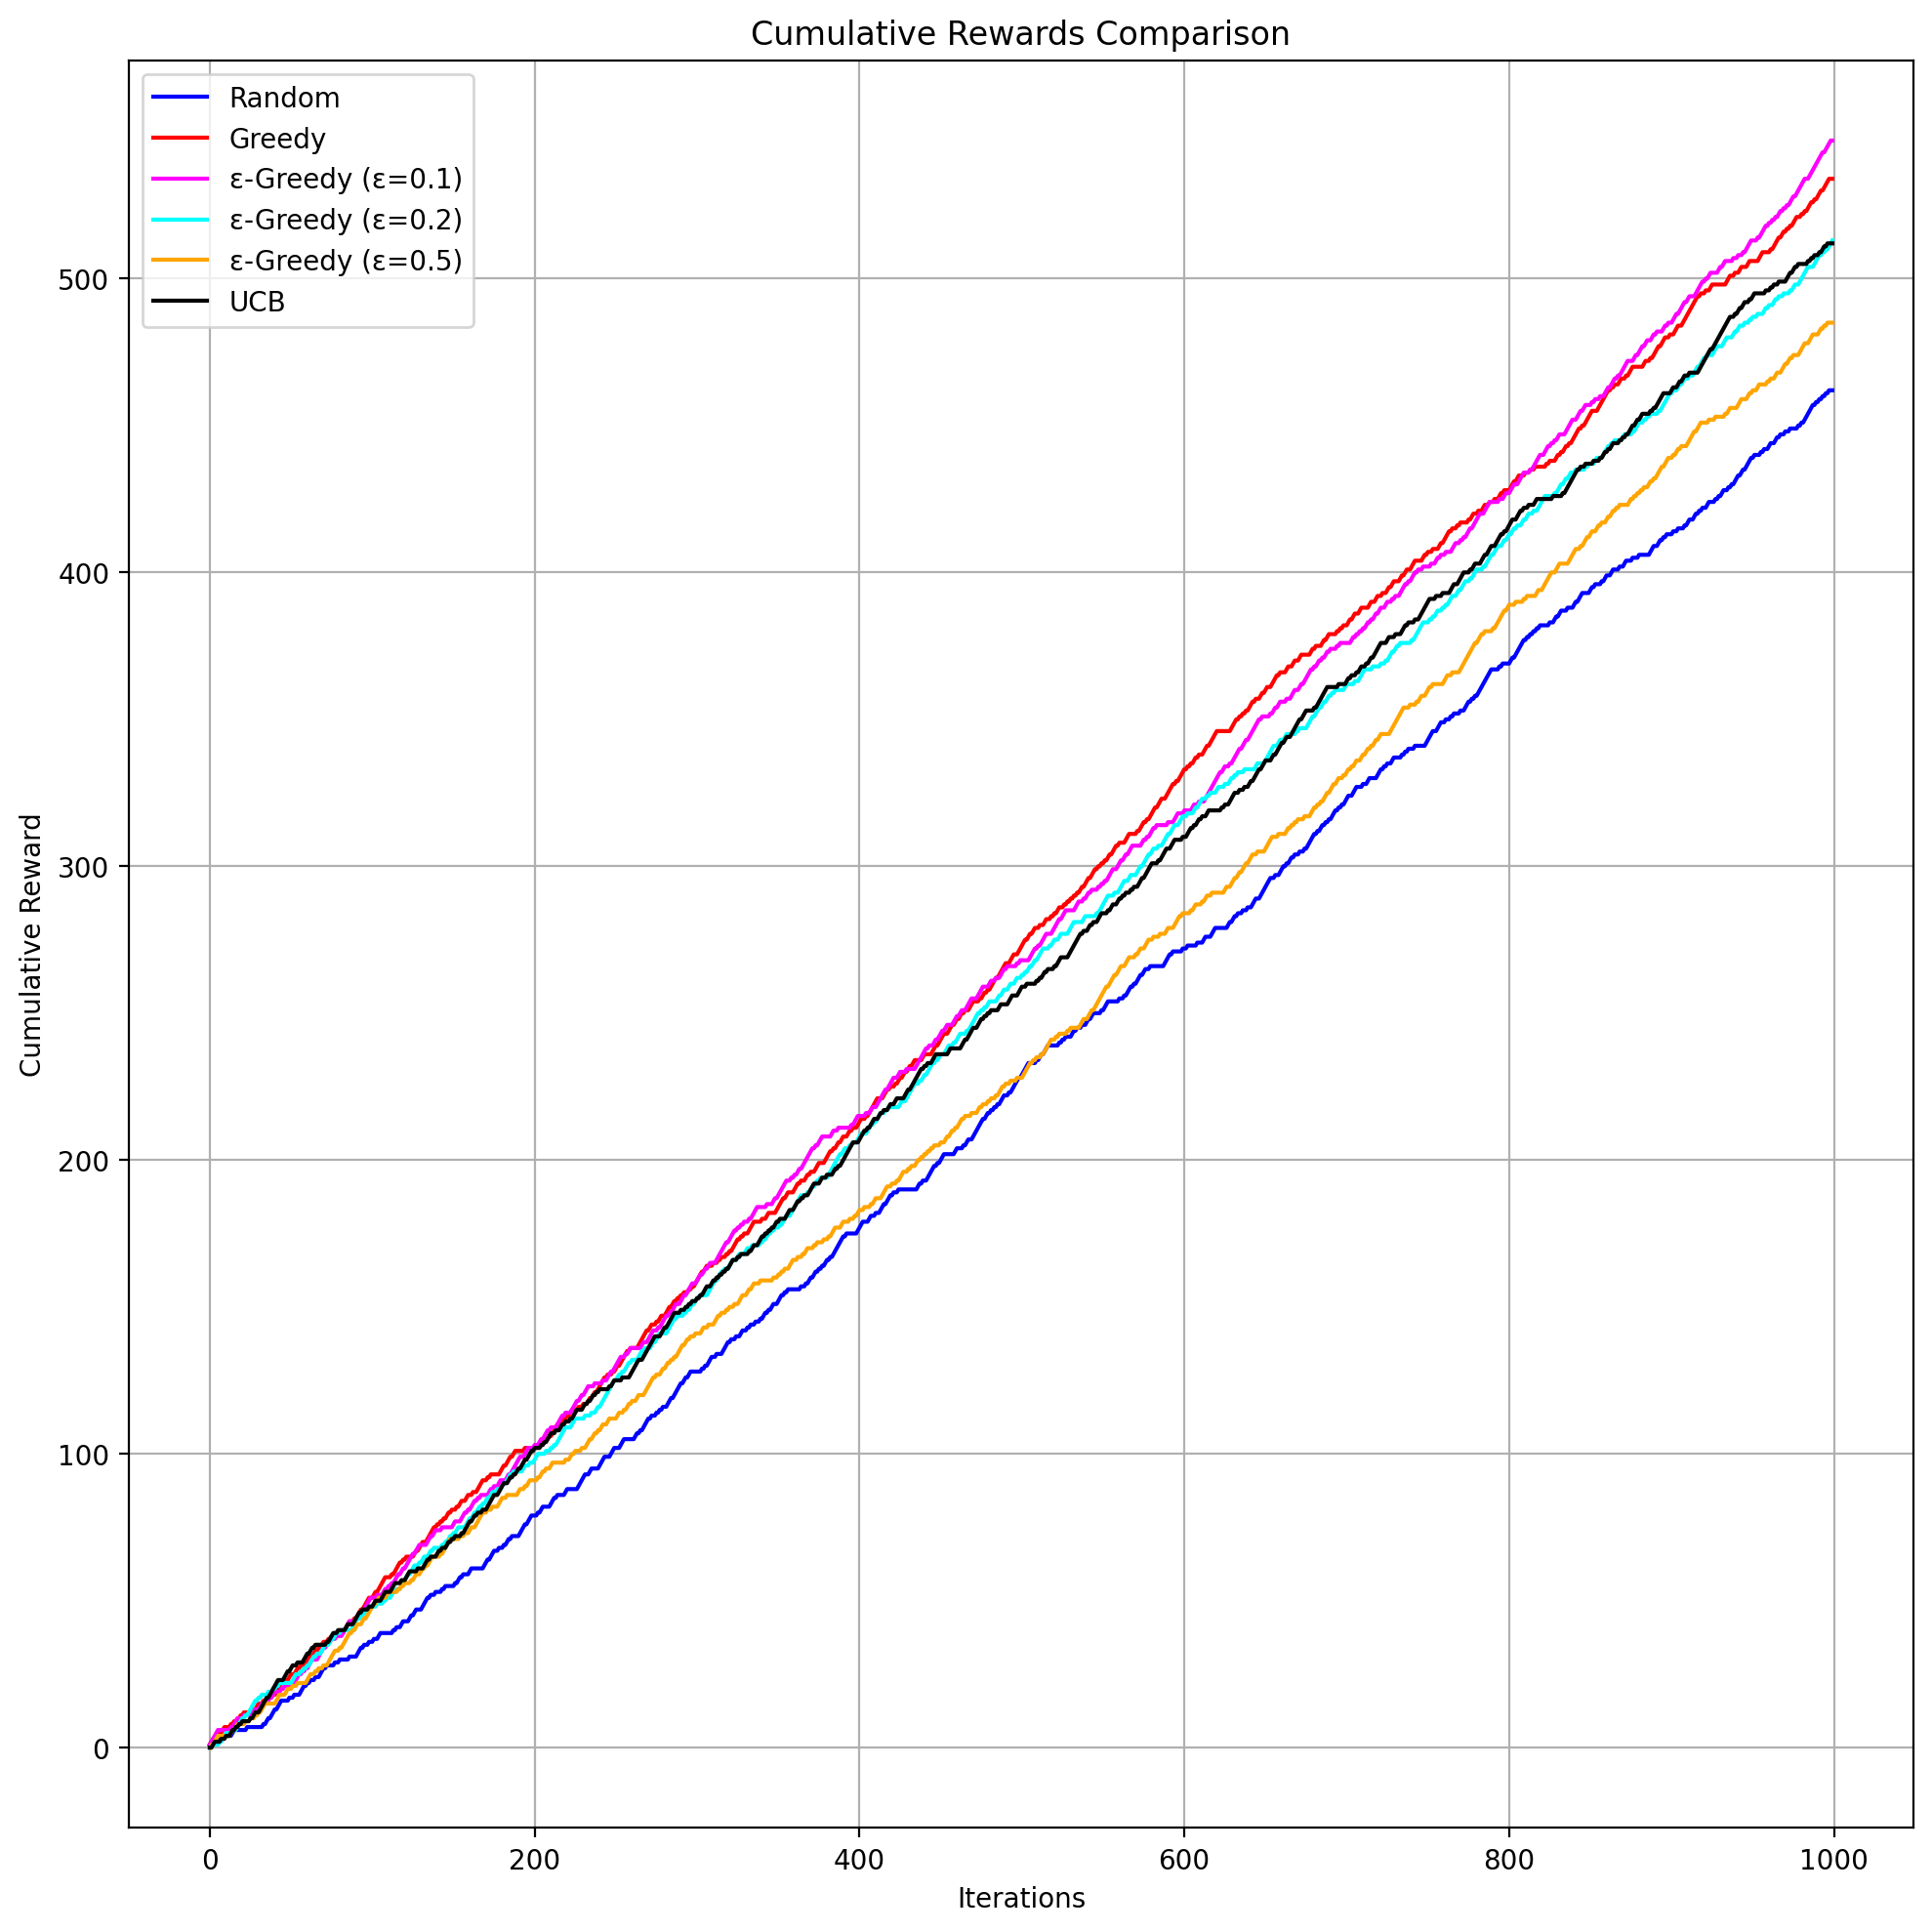

In [257]:
plt.figure(figsize=(10, 10), dpi=200)

for i, (name, rewards) in enumerate(plotting_data.items()):
    cumulative_rewards = np.cumsum(rewards)
    plt.plot(cumulative_rewards, label=name, color=colors[i])

plt.xlabel("Iterations")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Rewards Comparison")

plt.legend()
plt.grid(visible=True)

plt.tight_layout()
plt.show()

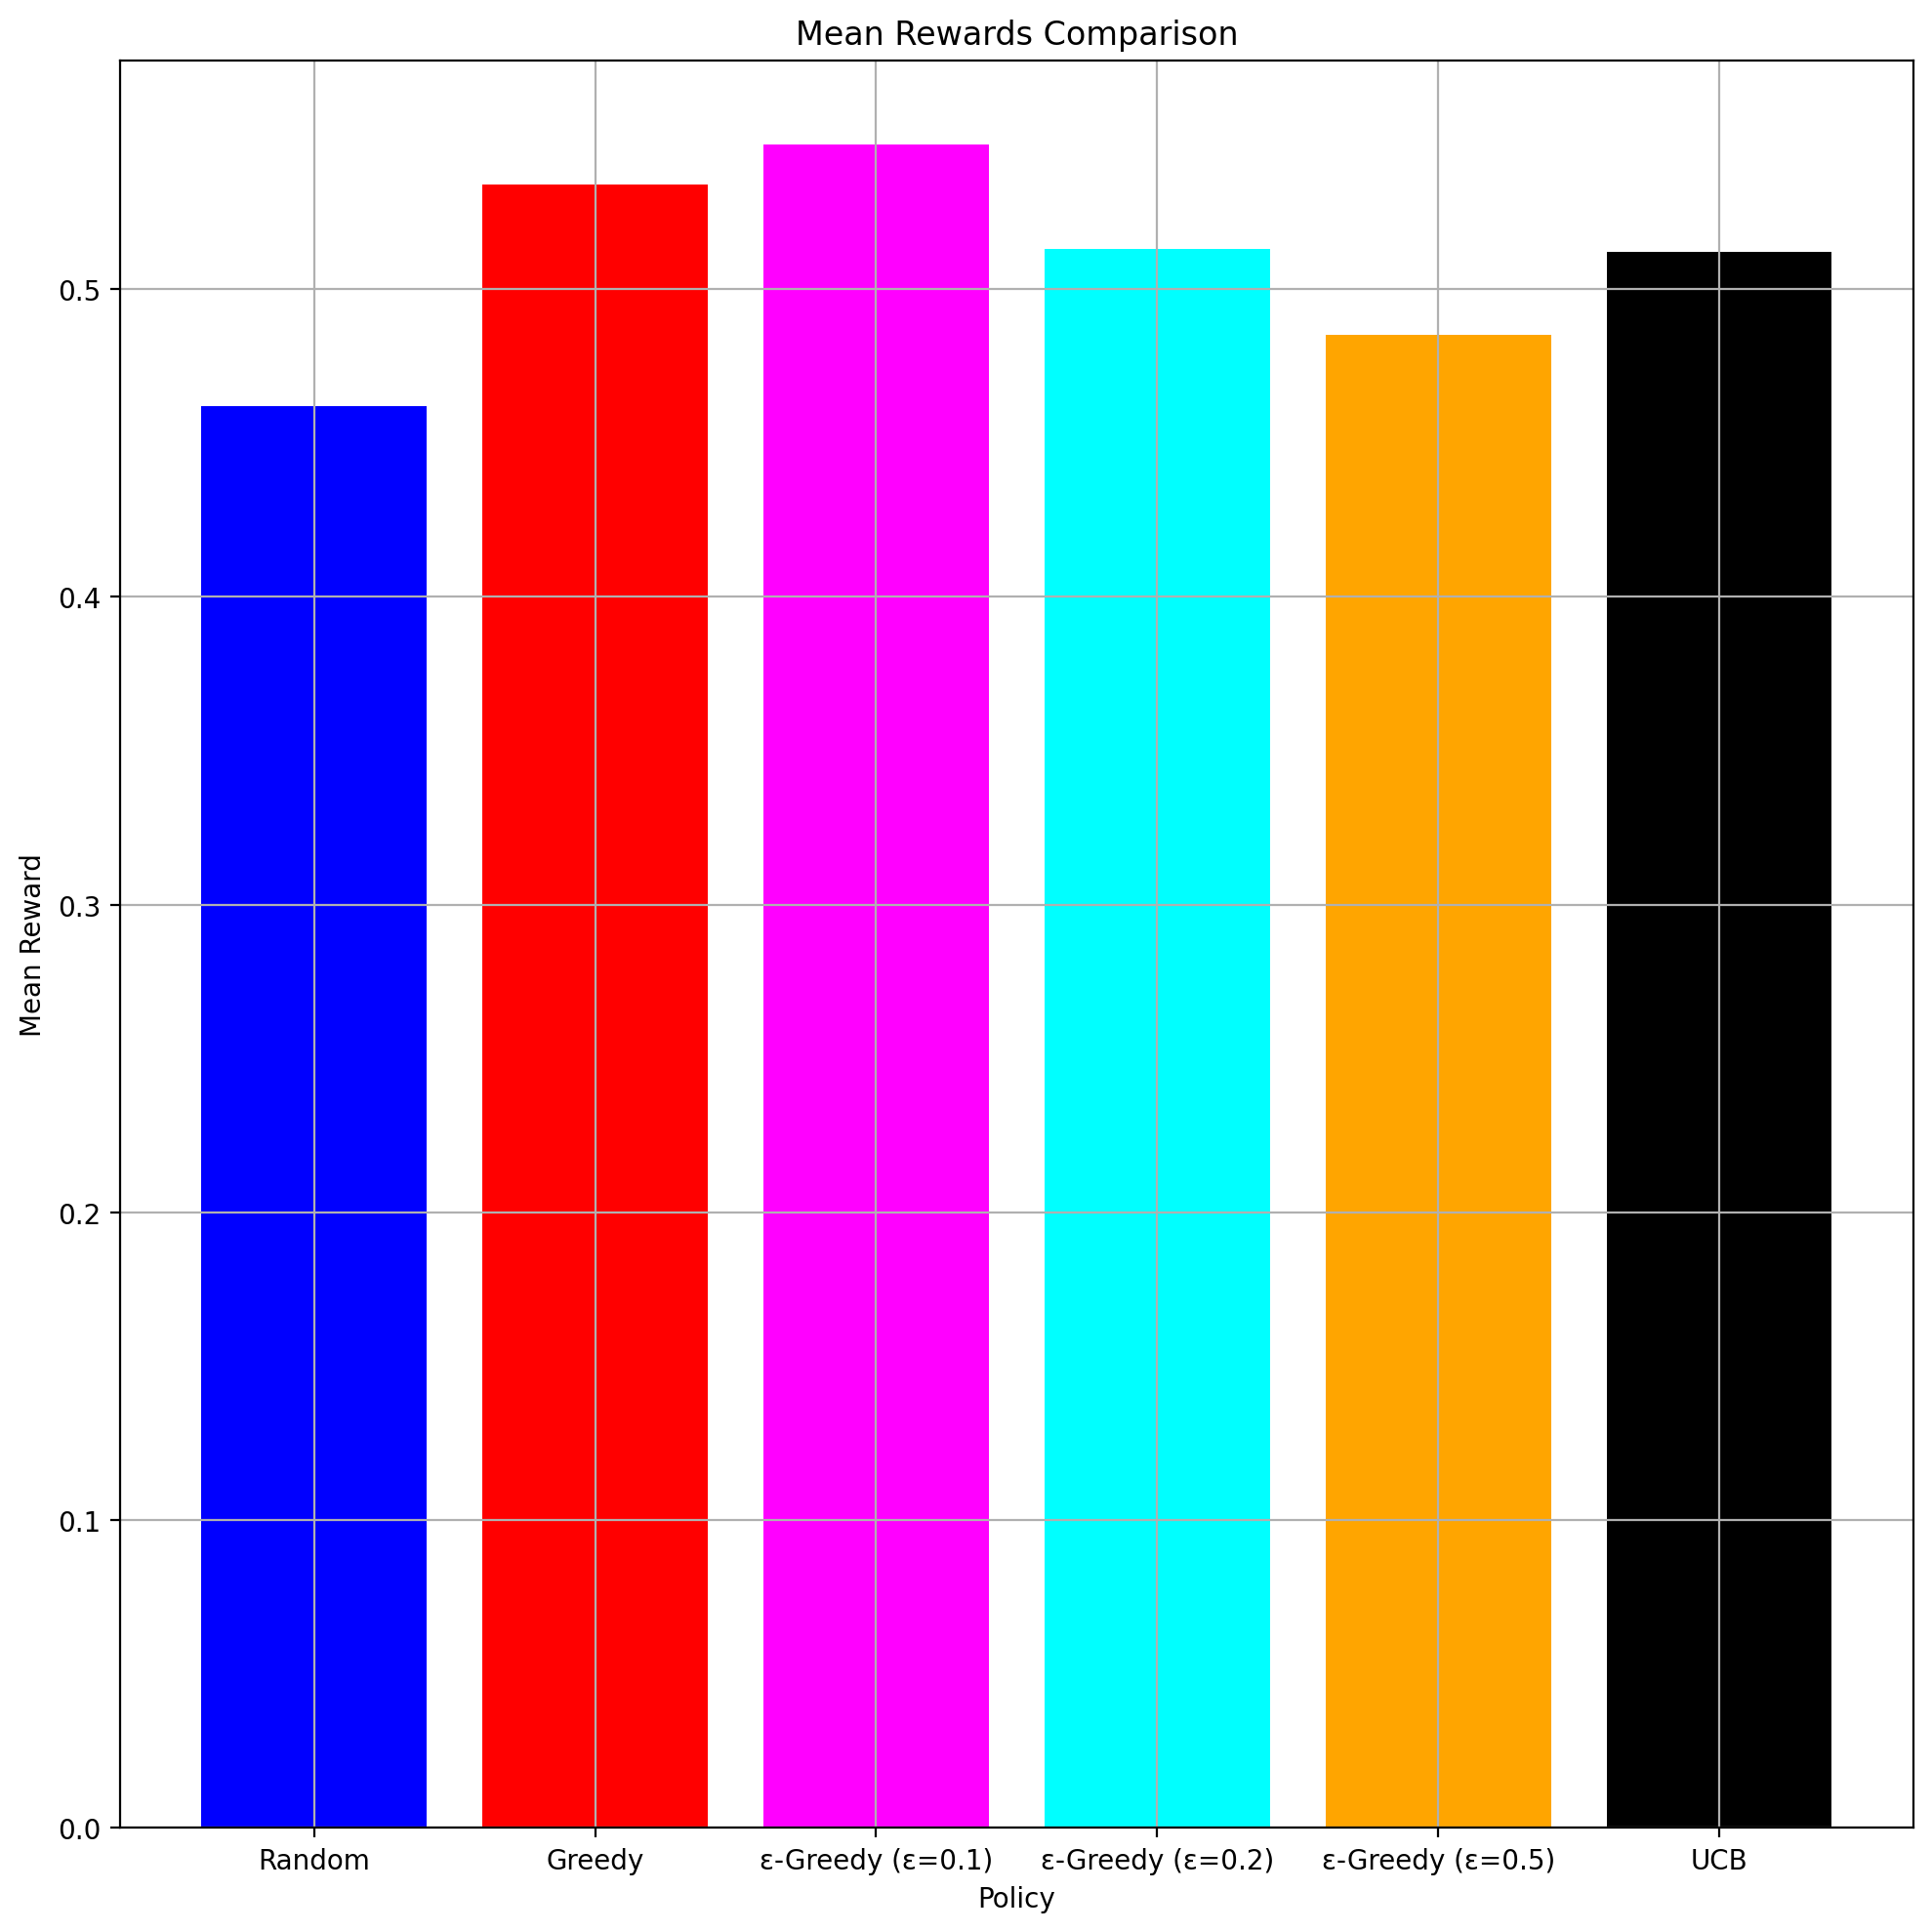

In [258]:
plt.figure(figsize=(10, 10), dpi=200)

mean_rewards_per_policy = {name: np.mean(rewards) for name, rewards in plotting_data.items()}

plt.bar(mean_rewards_per_policy.keys(), mean_rewards_per_policy.values(), color=colors)

plt.xlabel("Policy")
plt.ylabel("Mean Reward")
plt.title("Mean Rewards Comparison")
plt.grid(visible=True)

plt.tight_layout()
plt.show()

#### **Conclusion**

Based on the results we can see that cumulative and average values are high for UCB and
Epsilon greedy algorithms with low epsilon values.

The most effective algorithm was Epsilon greedy with epsilon = 0.1, which achieved the highest cumulative and average reward values.

The random policy explored the most but did not exploit the results. All the learning done will be useless in terms of random policy. But the greedy algorithm fails to understand the effectiveness of other available option. It immediately selects the best working option. There might have been a better option if explored. To find the best option we need the ability to explore and use the best option we need to exploit.
